# Web dataset

These are the results from [Daily website visitors](https://www.kaggle.com/datasets/bobnau/daily-website-visitors) from Kaggle. This dataset contains 5 years of daily time series data for several measures of traffic on a statistical forecasting teaching notes website whose alias is statforecasting.com. The dataset describes each feature day by day starting from 14-09-2014 to 19-08-2020.  The dataset has an amount of 2167 observations and 8 attributes: 

- **date**: `datetime`, the date of the record
- **unique_visitors**: `int`, daily number of visitors from whose IP addresses there haven't been hits on any page in over 6 hours
- **Unique.Visits**: `int`, number of unique visitors who do not have a cookie identifying them as a previous customer
- **First.Time.Visits**: `int`, number of unique visitors who do not have a cookie identifying them as a previous customer
- **Returning.Visits**: `int`, number of unique visitors minus first time visitors

The original dataset has been first preprocessed to respect the requirements needed for training the model, mainly dropping null values and dividing the time stamp into separated columns for each day, month and year.

## Imports and preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial.distance import cdist
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from scipy import stats
from statsmodels.tsa.stattools import acf


In [163]:
df = pd.read_csv('../Real_Datasets/daily-website-visitors.csv')
df.drop(['Row'], axis=1, inplace=True)
def remove_commas(x):
    return float(x.replace(',', ''))
df['Page.Loads'] = df['Page.Loads'].apply(lambda x : remove_commas(x))
df['Unique.Visits'] = df['Unique.Visits'].apply(lambda x : remove_commas(x))
df['First.Time.Visits'] = df['First.Time.Visits'].apply(lambda x : remove_commas(x))
df['Returning.Visits'] = df['Returning.Visits'].apply(lambda x : remove_commas(x))

In [164]:
df_filtered = df.copy()

In [165]:
df_filtered.drop(columns=['Day'], inplace=True)

In [166]:
df_filtered['Date'] = pd.to_datetime(df['Date'])

In [167]:
#df_filtered.to_csv('web_orig.csv', index=False)

## Synthetic data import

The dataset so preprocessed has been used to train the generative model. After that the synthetic data are here imported and preprocessed. Since the generation could not always work fine, the data are sometimes misgenerated in wrong format or completely out of bounds (for instance a temperature of 10k ºC), or even not generated. Thus the first thing done here is to convert, if needed, the data in the original format, remove the missing values and the values somehow out of the original values ranges, ensuring that these bounds are relxed to admit values out of the proper ranges but still significative for the analysis.

In [168]:
df_sin = pd.read_csv('synt_datasets/original_web_fromprompts.csv')

In [169]:
df_sin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2167 non-null   object 
 1   Page.Loads         2164 non-null   object 
 2   Unique.Visits      2162 non-null   float64
 3   First.Time.Visits  2166 non-null   float64
 4   Returning.Visits   2166 non-null   float64
 5   Day.Of.Week        2165 non-null   float64
dtypes: float64(4), object(2)
memory usage: 101.7+ KB


In [170]:
df_sin['Page.Loads'] = pd.to_numeric( df_sin['Page.Loads'], errors='coerce')
df_sin['Unique.Visits'] = pd.to_numeric( df_sin['Unique.Visits'], errors='coerce')
df_sin['First.Time.Visits'] = pd.to_numeric( df_sin['First.Time.Visits'], errors='coerce')
df_sin['Returning.Visits'] = pd.to_numeric( df_sin['Returning.Visits'], errors='coerce')

In [171]:
df_sin.dropna(inplace=True)

In [172]:
df_sin = df_sin[df_sin['Day.Of.Week'] <= 7]

In [173]:
df_sin['Day.Of.Week'] = df_sin['Day.Of.Week'].astype('category')
df_filtered['Day.Of.Week'] = df_filtered['Day.Of.Week'].astype('category')
df_sin['Day.Of.Week'] = df_sin['Day.Of.Week'].cat.codes
df_filtered['Day.Of.Week'] = df_filtered['Day.Of.Week'].cat.codes

In [174]:
df_sin['Date'] = pd.to_datetime(df_sin['Date'])

In [175]:
df_sin = df_sin[['Day.Of.Week',	'Date','Page.Loads', 'Unique.Visits',	'First.Time.Visits',	'Returning.Visits']]

In [176]:
df_sin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2155 entries, 0 to 2166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Day.Of.Week        2155 non-null   int8          
 1   Date               2155 non-null   datetime64[ns]
 2   Page.Loads         2155 non-null   float64       
 3   Unique.Visits      2155 non-null   float64       
 4   First.Time.Visits  2155 non-null   float64       
 5   Returning.Visits   2155 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int8(1)
memory usage: 103.1 KB


In [177]:
columns = df_filtered.columns.to_list()
excluded_columns = ['Date', 'Day.Of.Week']
for col in columns:
    if col not in excluded_columns:    
        print('\n', col, '\n\nReal ranges: ',  ' min ', df_filtered[col].min(), ' max ', df_filtered[col].max(),
              '\nSynthetic ranges: ', ' min ', df_sin[col].min(), ' max ', df_sin[col].max(),)


 Page.Loads 

Real ranges:   min  1002.0  max  7984.0 
Synthetic ranges:   min  3.0  max  7984.0

 Unique.Visits 

Real ranges:   min  667.0  max  5541.0 
Synthetic ranges:   min  17.0  max  5479.0

 First.Time.Visits 

Real ranges:   min  522.0  max  4616.0 
Synthetic ranges:   min  3.0  max  28033.0

 Returning.Visits 

Real ranges:   min  133.0  max  1036.0 
Synthetic ranges:   min  4.0  max  4835.0


In [178]:
df_sin = df_sin[df_sin['Page.Loads'] >= 600]
df_sin = df_sin[df_sin['Page.Loads'] <= 10000]

df_sin = df_sin[df_sin['Unique.Visits'] >= 400]

df_sin = df_sin[df_sin['First.Time.Visits'] >= 300]
df_sin = df_sin[df_sin['First.Time.Visits'] <= 6000]

df_sin = df_sin[df_sin['Returning.Visits'] <= 2000]


## EDA confront between synthetic and real values

Here we have a first sight to the continue variables marginal distributions of both the real and synthetic data, in order to check that the model has been able to catch the main properties of the data.

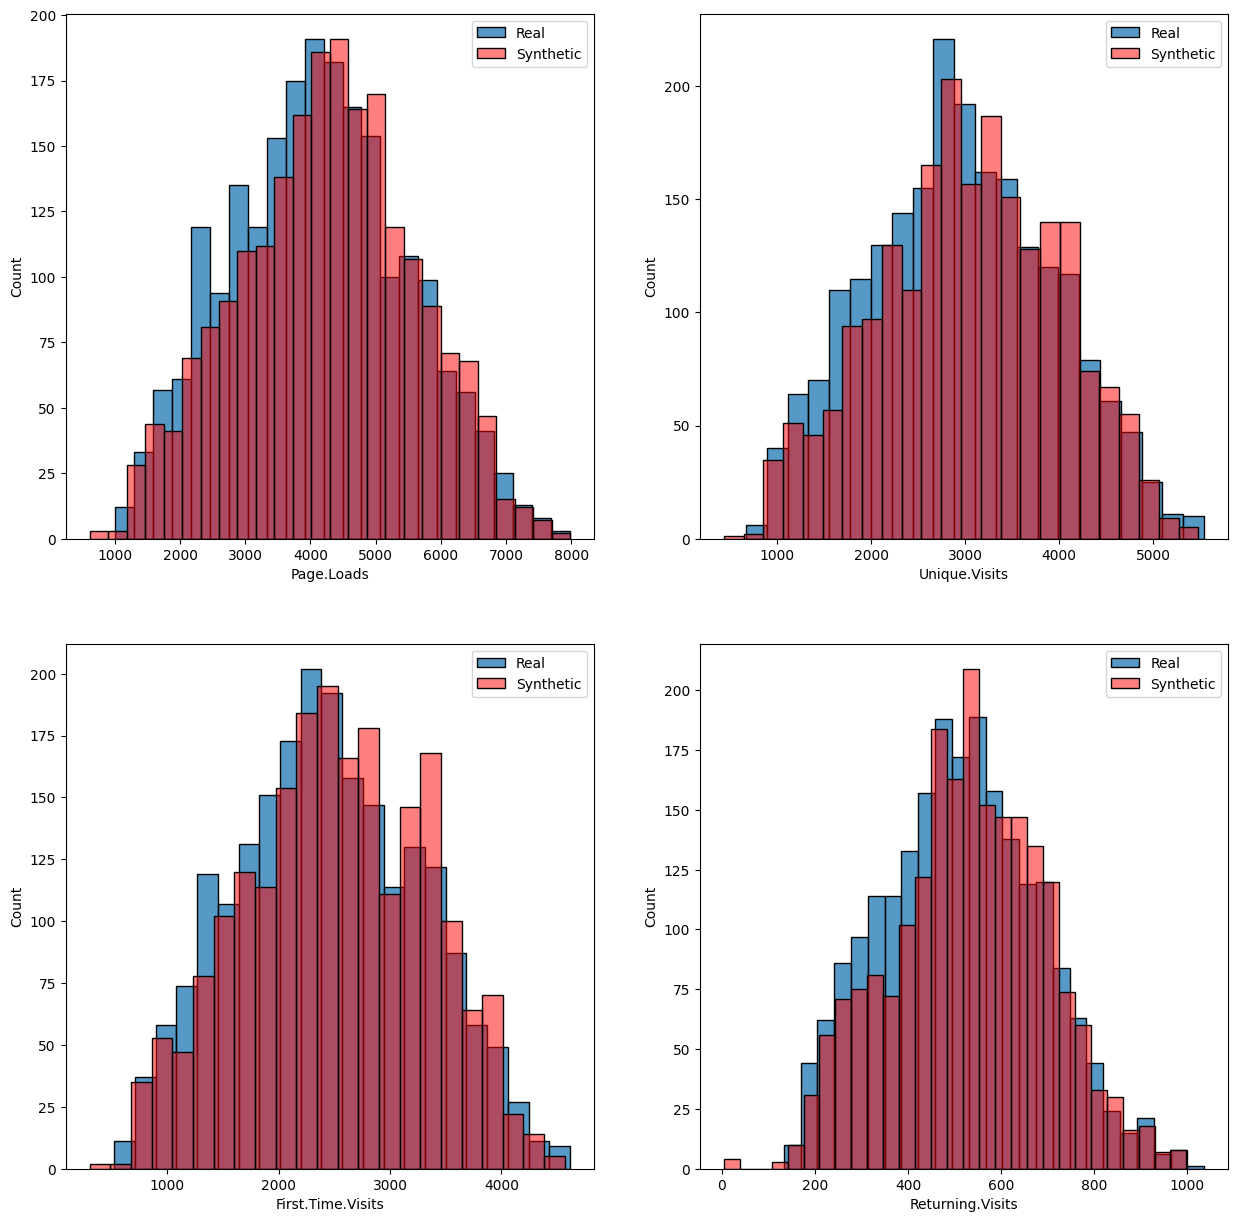

In [179]:
cols_to_plot = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
plt.figure(figsize=(15, 15))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df_filtered, x=col, label='Real')
    sns.histplot(data=df_sin, x=col, color='red', alpha=0.5, label='Synthetic')
    plt.legend()

In [180]:
df_real = df_filtered.copy()
df_synthetic = df_sin.copy()

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

kl_divergences = {}

for column in cols_to_plot:
    
    real_hist, _ = np.histogram(df_real[column], bins=50, density=True)
    synth_hist, _ = np.histogram(df_synthetic[column], bins=50, density=True)
    
    real_hist = real_hist + 1e-10
    synth_hist = synth_hist + 1e-10
    
    real_hist = real_hist / np.sum(real_hist)
    synth_hist = synth_hist / np.sum(synth_hist)
    
    kl_div = kl_divergence(real_hist, synth_hist)
    kl_divergences[column] = kl_div

print("KL Divergences:")
for column, kl_div in kl_divergences.items():
    print(f"{column}: {kl_div:.2f}")

KL Divergences:
Page.Loads: 0.08
Unique.Visits: 0.15
First.Time.Visits: 0.17
Returning.Visits: 0.98


In order to check the temporal properties of the data we set the timestamp back to the original format, so that the models can handle it.

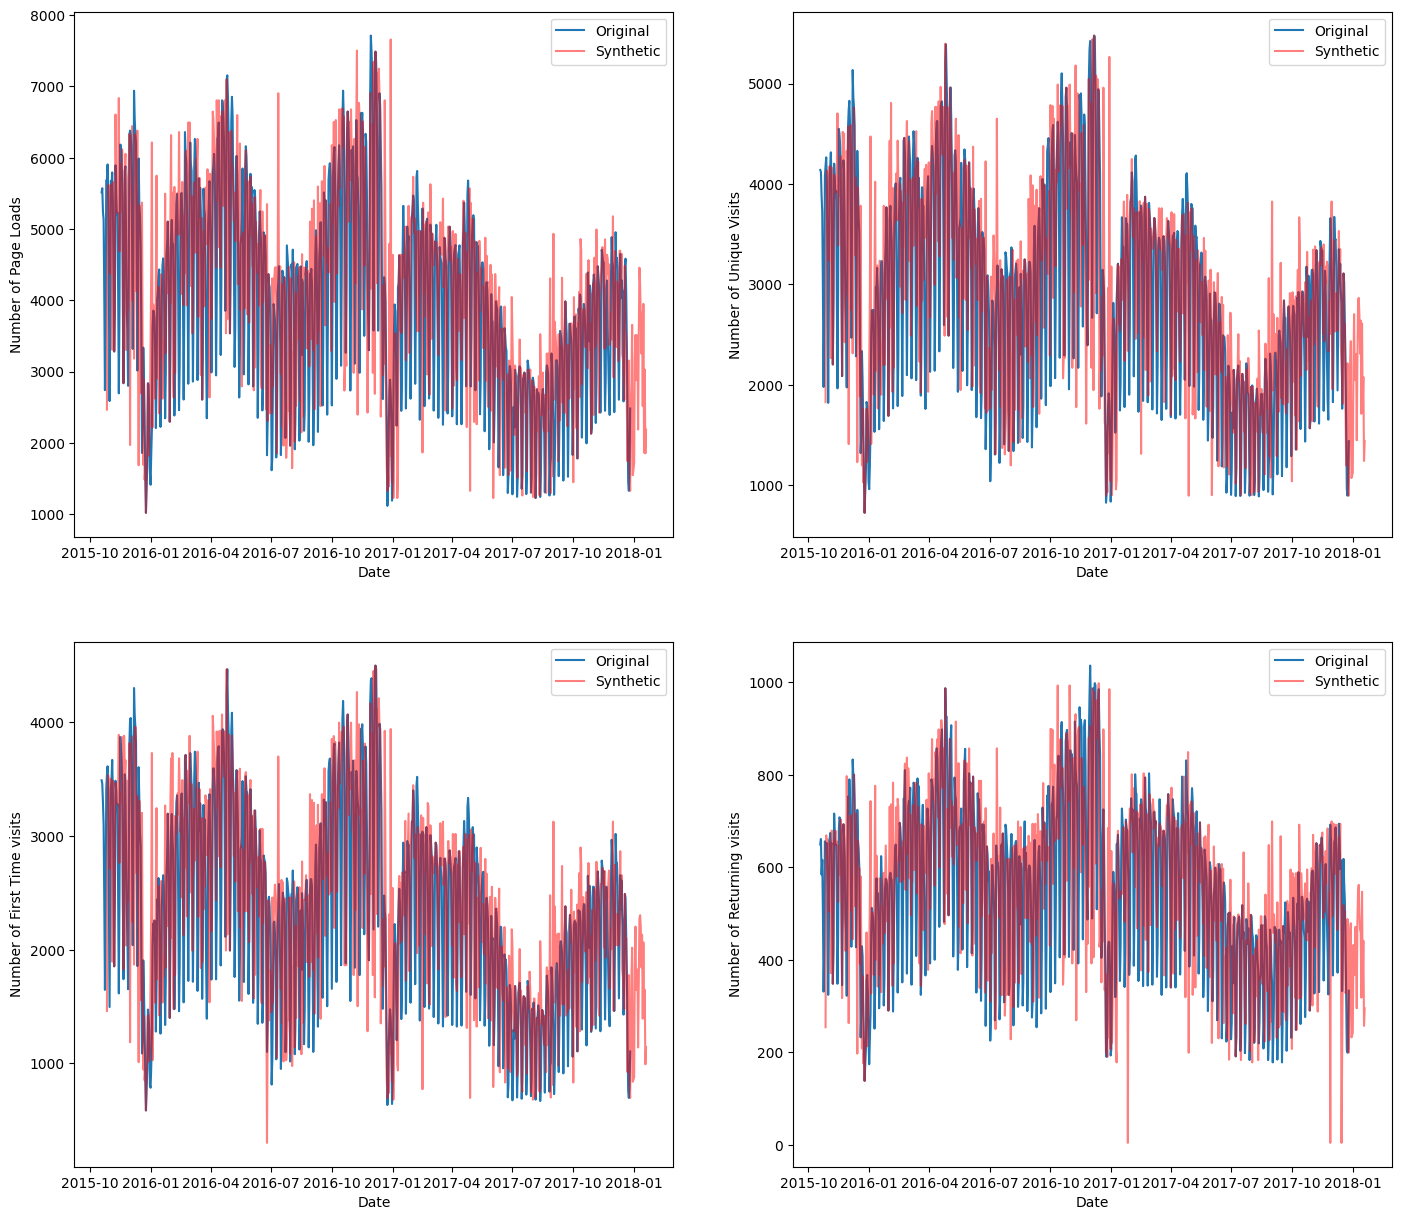

In [181]:
start,end = 400,1200
figure, ax = plt.subplots(2, 2, figsize=(17, 15))

ax1 = ax[0]
ax2 = ax[1]

ax1[0].plot(df_filtered.iloc[start:end]['Date'], df_filtered.iloc[start:end]['Page.Loads'], label='Original')
ax1[0].plot(df_sin.iloc[start:end]['Date'], df_sin.iloc[start:end]['Page.Loads'], color='red', alpha=0.5, label='Synthetic')
ax1[0].set_xlabel("Date")
ax1[0].set_ylabel("Number of Page Loads")
ax1[0].legend()

ax1[1].plot(df_filtered.iloc[start:end]['Date'], df_filtered.iloc[start:end]['Unique.Visits'], label='Original')
ax1[1].plot(df_sin.iloc[start:end]['Date'], df_sin.iloc[start:end]['Unique.Visits'], color='red', alpha=0.5,label='Synthetic')
ax1[1].set_xlabel("Date")
ax1[1].set_ylabel("Number of Unique Visits")
ax1[1].legend()

ax2[0].plot(df_filtered.iloc[start:end]['Date'], df_filtered.iloc[start:end]['First.Time.Visits'], label='Original')
ax2[0].plot(df_sin.iloc[start:end]['Date'], df_sin.iloc[start:end]['First.Time.Visits'], color='red', alpha=0.5,label='Synthetic')
ax2[0].set_xlabel("Date")
ax2[0].set_ylabel("Number of First Time visits")
ax2[0].legend()

ax2[1].plot(df_filtered.iloc[start:end]['Date'], df_filtered.iloc[start:end]['Returning.Visits'], label='Original')
ax2[1].plot(df_sin.iloc[start:end]['Date'], df_sin.iloc[start:end]['Returning.Visits'], color='red', alpha=0.5,label='Synthetic')
ax2[1].set_xlabel("Date")
ax2[1].set_ylabel("Number of Returning visits")
ax2[1].legend()

In [182]:
df_real = df_filtered.drop(columns=['Date', 'Day.Of.Week'])
df_synthetic = df_sin.drop(columns=['Date', 'Day.Of.Week'])

max_lag = 8
autocorrelations = {}

for column in df_real.columns:
    real_acf = acf(df_real[column], nlags=max_lag)
    synth_acf = acf(df_synthetic[column], nlags=max_lag)
    
    autocorrelations[column] = {
        'real': real_acf,
        'synthetic': synth_acf
    }


print("\nAutocorrelations:")
for column, acfs in autocorrelations.items():
    print(f"\n{column}:")
    print("Lag\tReal\tSynthetic")
    for lag in range(max_lag + 1):
        print(f"{lag}\t{acfs['real'][lag]:.4f}\t{acfs['synthetic'][lag]:.4f}")


Autocorrelations:

Page.Loads:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7451	0.4855
2	0.3466	0.4588
3	0.1453	0.4575
4	0.1339	0.4387
5	0.3110	0.4414
6	0.6787	0.4410
7	0.8942	0.4218
8	0.6497	0.4360

Unique.Visits:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7579	0.4887
2	0.3709	0.4761
3	0.1729	0.4751
4	0.1610	0.4554
5	0.3341	0.4624
6	0.6900	0.4684
7	0.8952	0.4392
8	0.6587	0.4554

First.Time.Visits:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7689	0.5087
2	0.3971	0.4824
3	0.2026	0.4768
4	0.1904	0.4621
5	0.3597	0.4752
6	0.7001	0.4757
7	0.8928	0.4518
8	0.6683	0.4642

Returning.Visits:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7243	0.4589
2	0.3364	0.4404
3	0.1645	0.4358
4	0.1552	0.4234
5	0.3082	0.4348
6	0.6693	0.4343
7	0.8972	0.4061
8	0.6450	0.4242


### Daily trends

Since the dataset offers a variable that indicates the day of the week of each row we now check if the daily trends are reproduced

In [183]:
day_grouped_data = df_filtered.groupby('Day.Of.Week')
day_grouped_data_sin = df_sin.groupby('Day.Of.Week')

In [184]:
def day_wise_EDA(day):

    day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    day_name = day_names[day]

    sun_data = day_grouped_data.get_group(day)
    sin_sun_data = day_grouped_data_sin.get_group(day)
    
    figure, ax = plt.subplots(2, 2, figsize=(17, 15))

    ax1 = ax[0]
    ax2 = ax[1]

    print(f"=================================================== {day_name.upper()} ANALYSIS =========================================")
    ax1[0].plot(sun_data['Date'], sun_data['Page.Loads'], label='Original')
    ax1[0].plot(sin_sun_data['Date'], sin_sun_data['Page.Loads'], color='red', alpha=0.5, label='Synthetic')
    ax1[0].set_xlabel("Date")
    ax1[0].set_ylabel("Number of Page Loads")
    ax1[0].legend()

    ax1[1].plot(sun_data['Date'], sun_data['Unique.Visits'], label='Original')
    ax1[1].plot(sin_sun_data['Date'], sin_sun_data['Unique.Visits'], color='red', alpha=0.5, label='Synthetic')
    ax1[1].set_xlabel("Date")
    ax1[1].set_ylabel("Number of Unique Visits")
    ax1[1].legend()

    ax2[0].plot(sun_data['Date'], sun_data['First.Time.Visits'], label='Original')
    ax2[0].plot(sin_sun_data['Date'], sin_sun_data['First.Time.Visits'], color='red', alpha=0.5, label='Synthetic')
    ax2[0].set_xlabel("Date")
    ax2[0].set_ylabel("Number of First Time visits")
    ax2[0].legend()

    ax2[1].plot(sun_data['Date'], sun_data['Returning.Visits'], label='Original')
    ax2[1].plot(sin_sun_data['Date'], sin_sun_data['Returning.Visits'], color='red', alpha=0.5, label='Synthetic')
    ax2[1].set_xlabel("Date")
    ax2[1].set_ylabel("Number of Returning visits")
    ax2[1].legend()


=================================================== MONDAY ANALYSIS =========================================


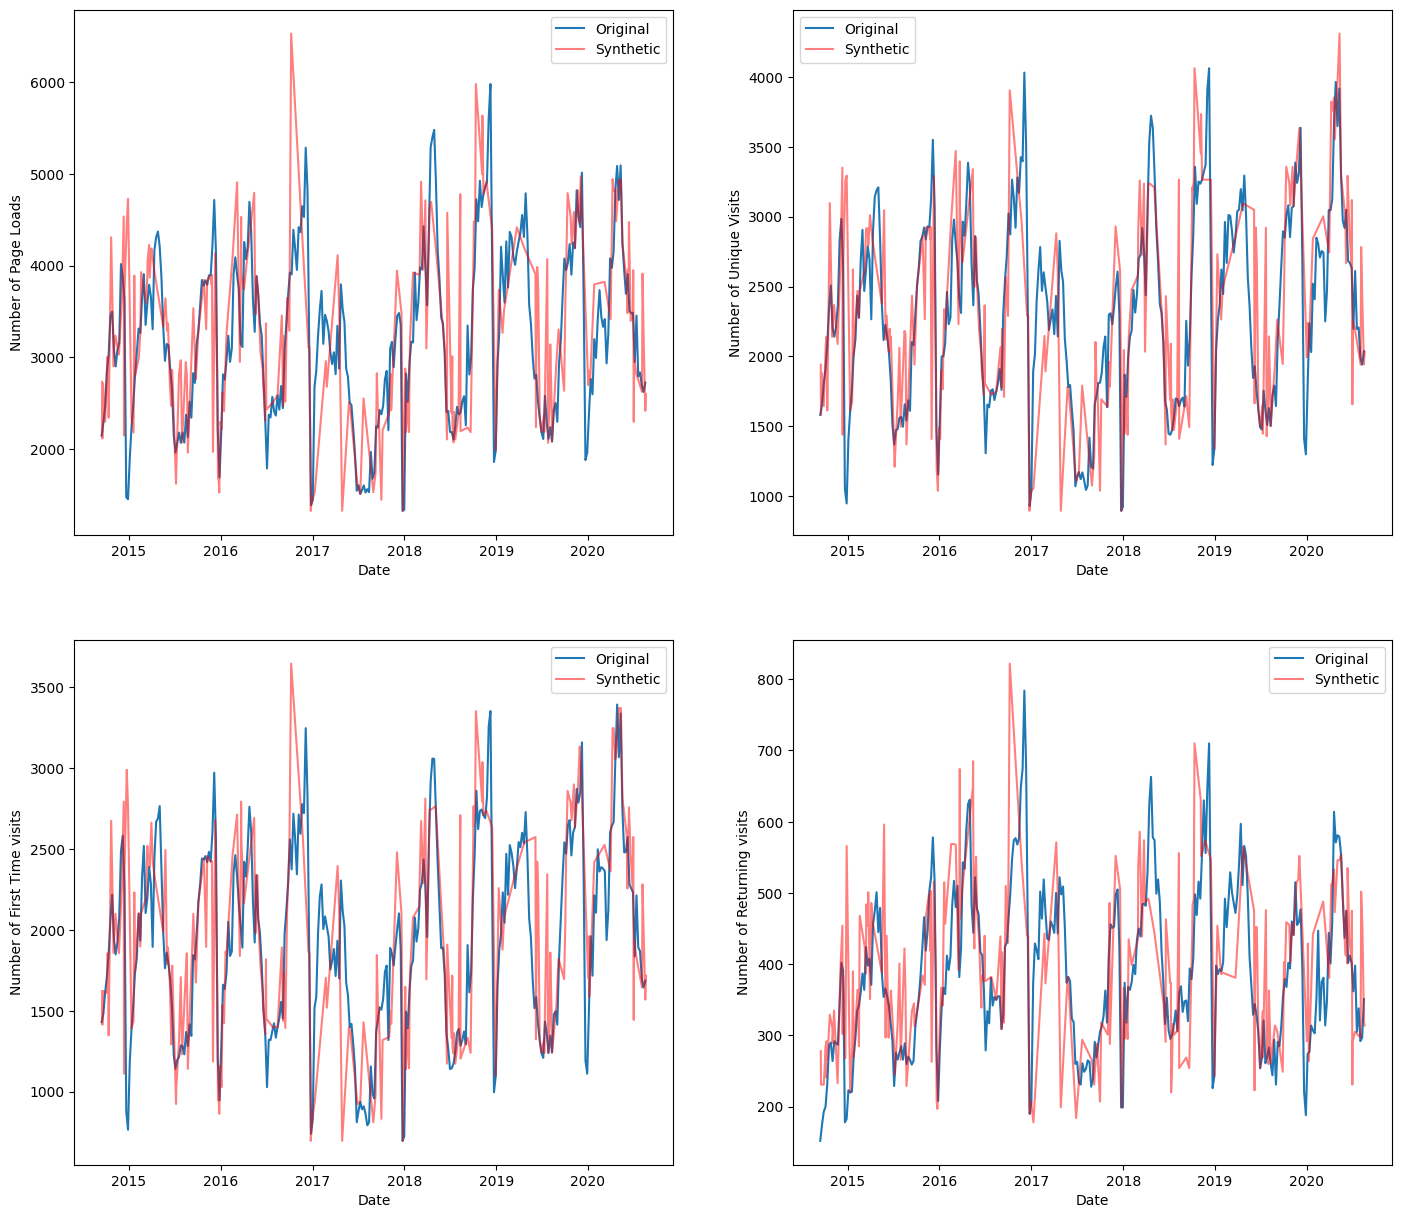

In [185]:
day_wise_EDA(0)

In [186]:
avg_day_data = day_grouped_data.mean().reset_index()
avg_day_sin_data = day_grouped_data_sin.mean().reset_index()

In [187]:
avg_day_data

,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,0,2017-08-30 12:00:00,3246.980645,2341.270968,1949.025806,392.245161
1,1,2017-08-31 12:00:00,4845.680645,3458.425806,2858.180645,600.245161
2,2,2017-09-01 12:00:00,4955.335484,3539.293548,2928.232258,611.061290
3,3,2017-09-02 12:00:00,4893.916129,3502.012903,2895.490323,606.522581
4,4,2017-08-31 00:00:00,4651.355987,3327.553398,2747.317152,580.236246
5,5,2017-09-01 00:00:00,3719.860841,2646.770227,2164.417476,482.352751
6,6,2017-09-02 00:00:00,2501.025890,1786.747573,1477.181230,309.566343


In [188]:
avg_day_sin_data

,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,0,2017-07-21 12:21:05.271966464,3237.790795,2328.589958,1940.108787,386.924686
1,1,2017-09-25 16:10:31.232876800,4892.663014,3506.673973,2887.063014,612.684932
2,2,2017-08-31 10:52:58.378378496,4949.321321,3534.456456,2920.618619,609.381381
3,3,2017-10-22 14:55:23.076923136,4864.929487,3505.766026,2886.227564,611.019231
4,4,2017-09-24 09:43:54.146341376,4676.118902,3343.048780,2775.682927,583.381098
5,5,2017-08-27 01:05:03.614457856,3744.629518,2674.740964,2185.177711,481.484940
6,6,2017-06-06 22:22:15.746606336,2471.710407,1762.135747,1462.389140,312.434389


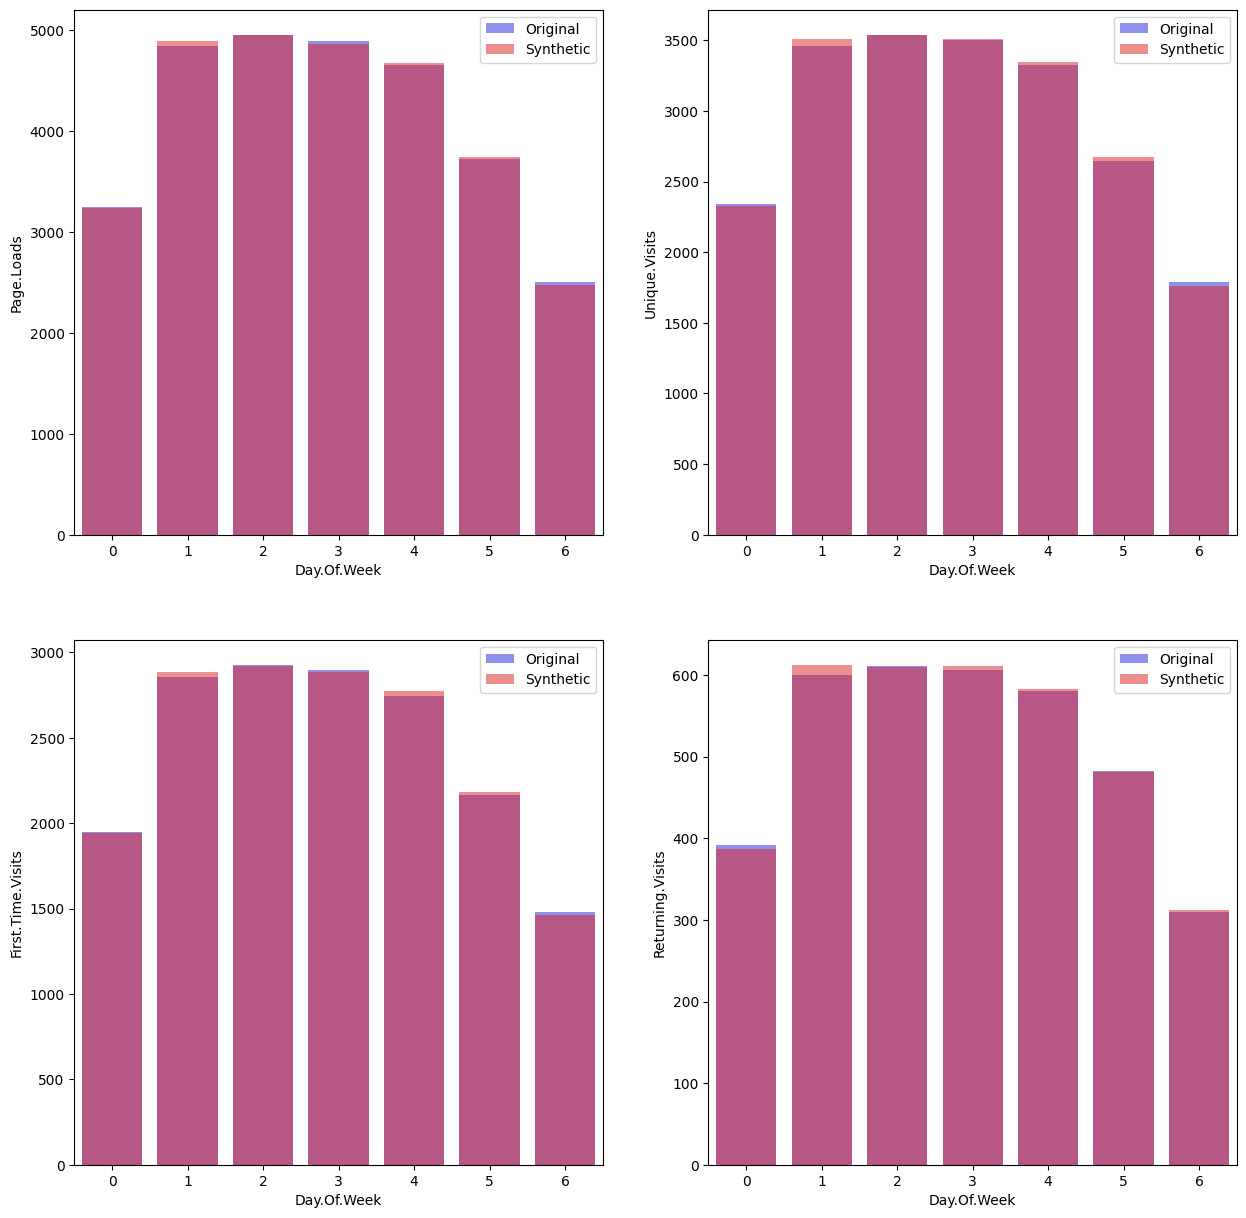

In [189]:
cols_to_plot = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
plt.figure(figsize=(15, 15))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.barplot(data=avg_day_data.sort_values(by=col, ascending=False), x='Day.Of.Week', y=col, color='blue', alpha=0.5, label='Original')
    sns.barplot(data=avg_day_sin_data.sort_values(by=col, ascending=False), x='Day.Of.Week', y=col, color = 'red', alpha=0.5, label='Synthetic')
    plt.legend()

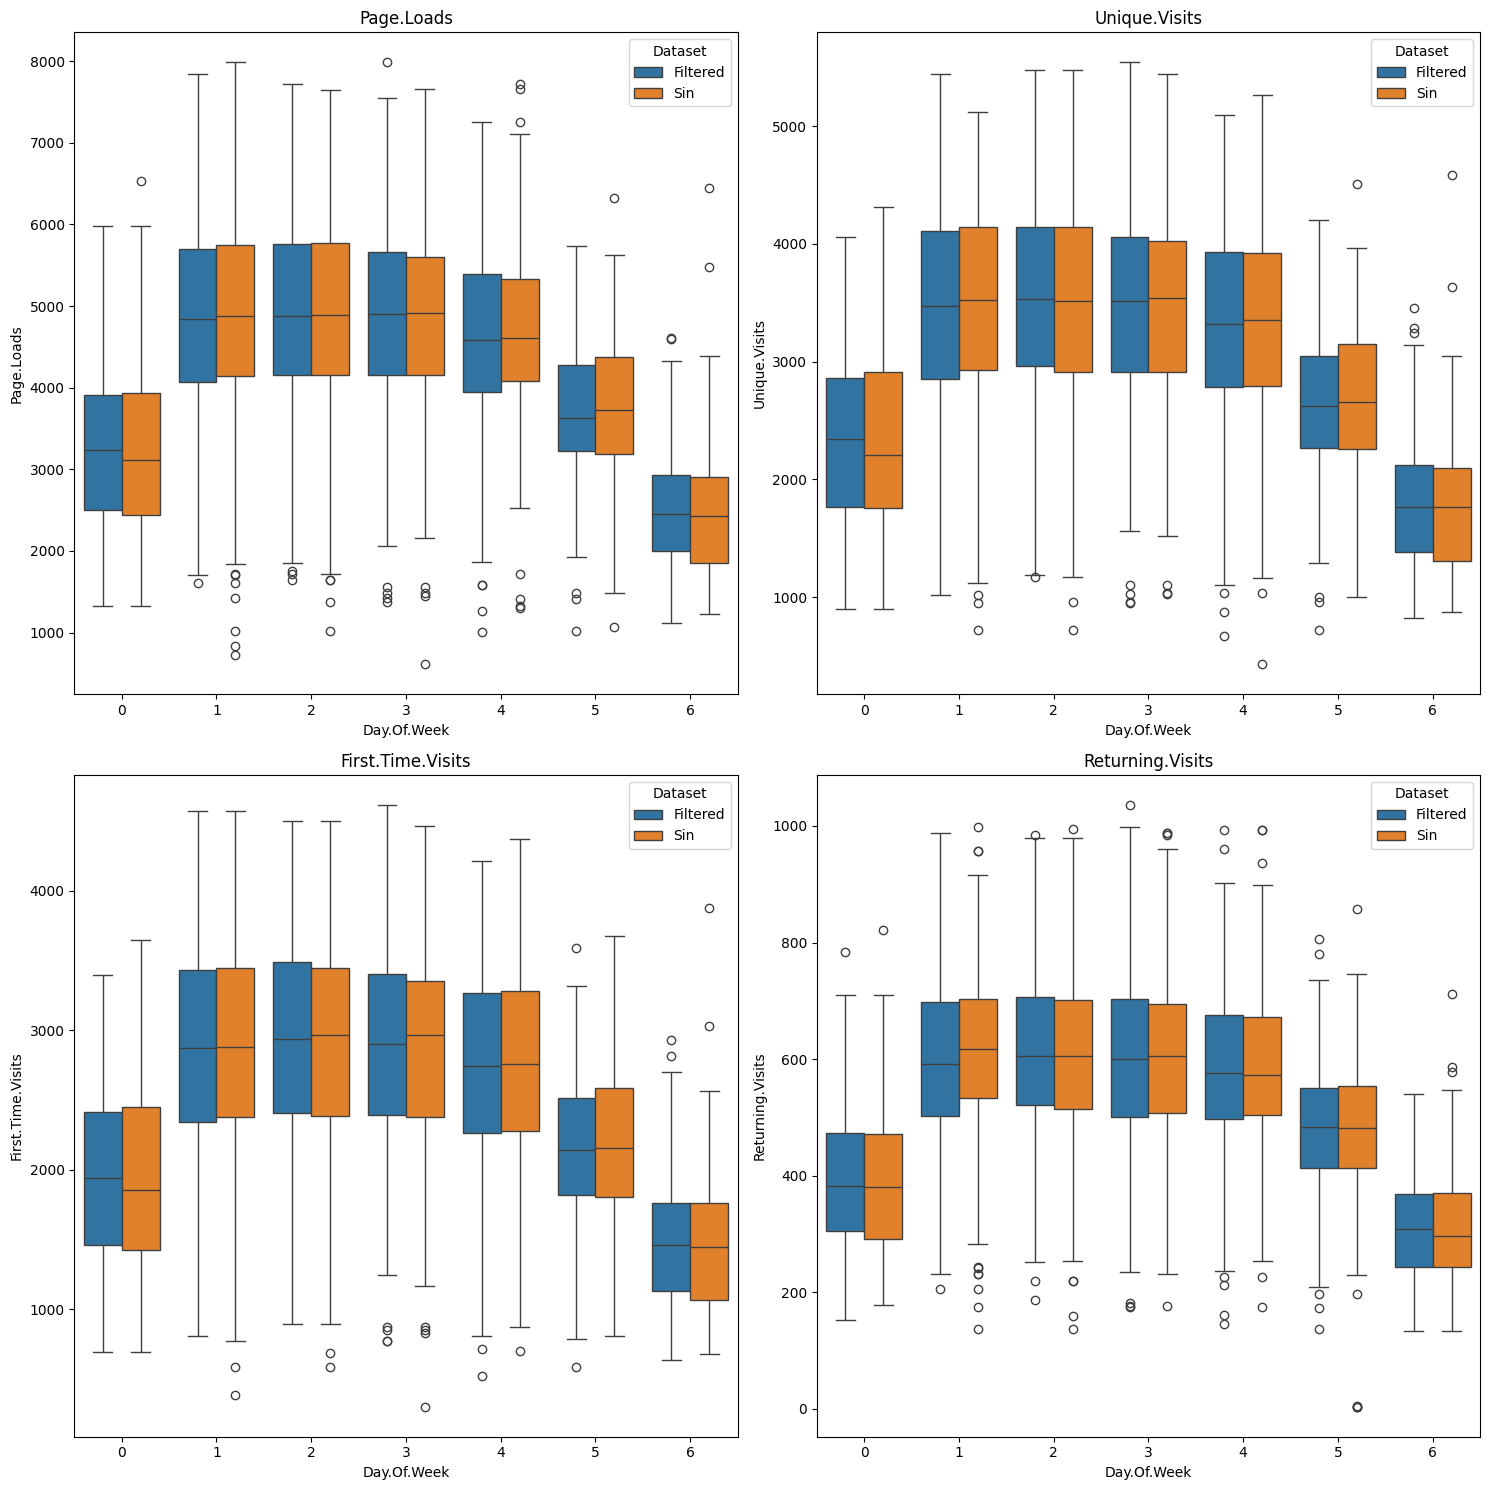

In [190]:
df_filtered['Dataset'] = 'Filtered'
df_sin['Dataset'] = 'Sin'
combined_df = pd.concat([df_filtered, df_sin])

cols_to_plot = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']

plt.figure(figsize=(15, 15))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=combined_df, x='Day.Of.Week', y=col, hue='Dataset')
    plt.title(col)
plt.tight_layout()
plt.show()

df_filtered.drop(columns=['Dataset'], inplace=True)
df_sin.drop(columns=['Dataset'], inplace=True)

## Evaluation

We now evaluate the quality of the data. 

### Copied values

First of all we'd like to have an insight on the synthetic data row-wise, we check if row by row there are copied values of the real data and, if there, how many they are.

In [191]:
def compute_equals(df1, df2, col_to_drop):

    df1['Date'] = pd.to_datetime(df1['Date'])
    df2['Date'] = pd.to_datetime(df2['Date'])
    
    matching_df1 = df1[df1['Date'].isin(df2['Date'])].copy()
    matching_df2 = df2[df2['Date'].isin(df1['Date'])].copy()
    original_indices = matching_df2.index
    
    matching_df1 = matching_df1.sort_values(by='Date').reset_index(drop=True)
    matching_df2 = matching_df2.sort_values(by='Date').reset_index(drop=True)

    matching_df1 = matching_df1.drop(columns=col_to_drop)
    matching_df2 = matching_df2.drop(columns=col_to_drop)

    numeric_cols = matching_df1.select_dtypes(include=[np.number]).columns
    
    results = []
    columns_matched = []
    summary_counter = Counter()
    matched_indices = []

    for i in range(len(matching_df1)):

        common_values = (matching_df1.loc[i, numeric_cols] == matching_df2.loc[i, numeric_cols])
        count_common = common_values.sum()
        matched_columns = numeric_cols[common_values].tolist()
        
        results.append(count_common)
        columns_matched.append(matched_columns)
        
        summary_counter.update(matched_columns)
        
        if count_common > 0:
            matched_indices.append({'index': original_indices[i], 'matched_columns': matched_columns})

    summary_report = dict(summary_counter)

    return results, columns_matched, summary_report, matched_indices


Since `day` is a categorical variable in range [0,6], this variable values should be equal to the real, thus it makes no sense to check they are different from the real values. 

In [192]:
cols_to_drop = ['Day.Of.Week']

In [193]:
distances, _, report, _ = compute_equals(df_filtered, df_sin, cols_to_drop)

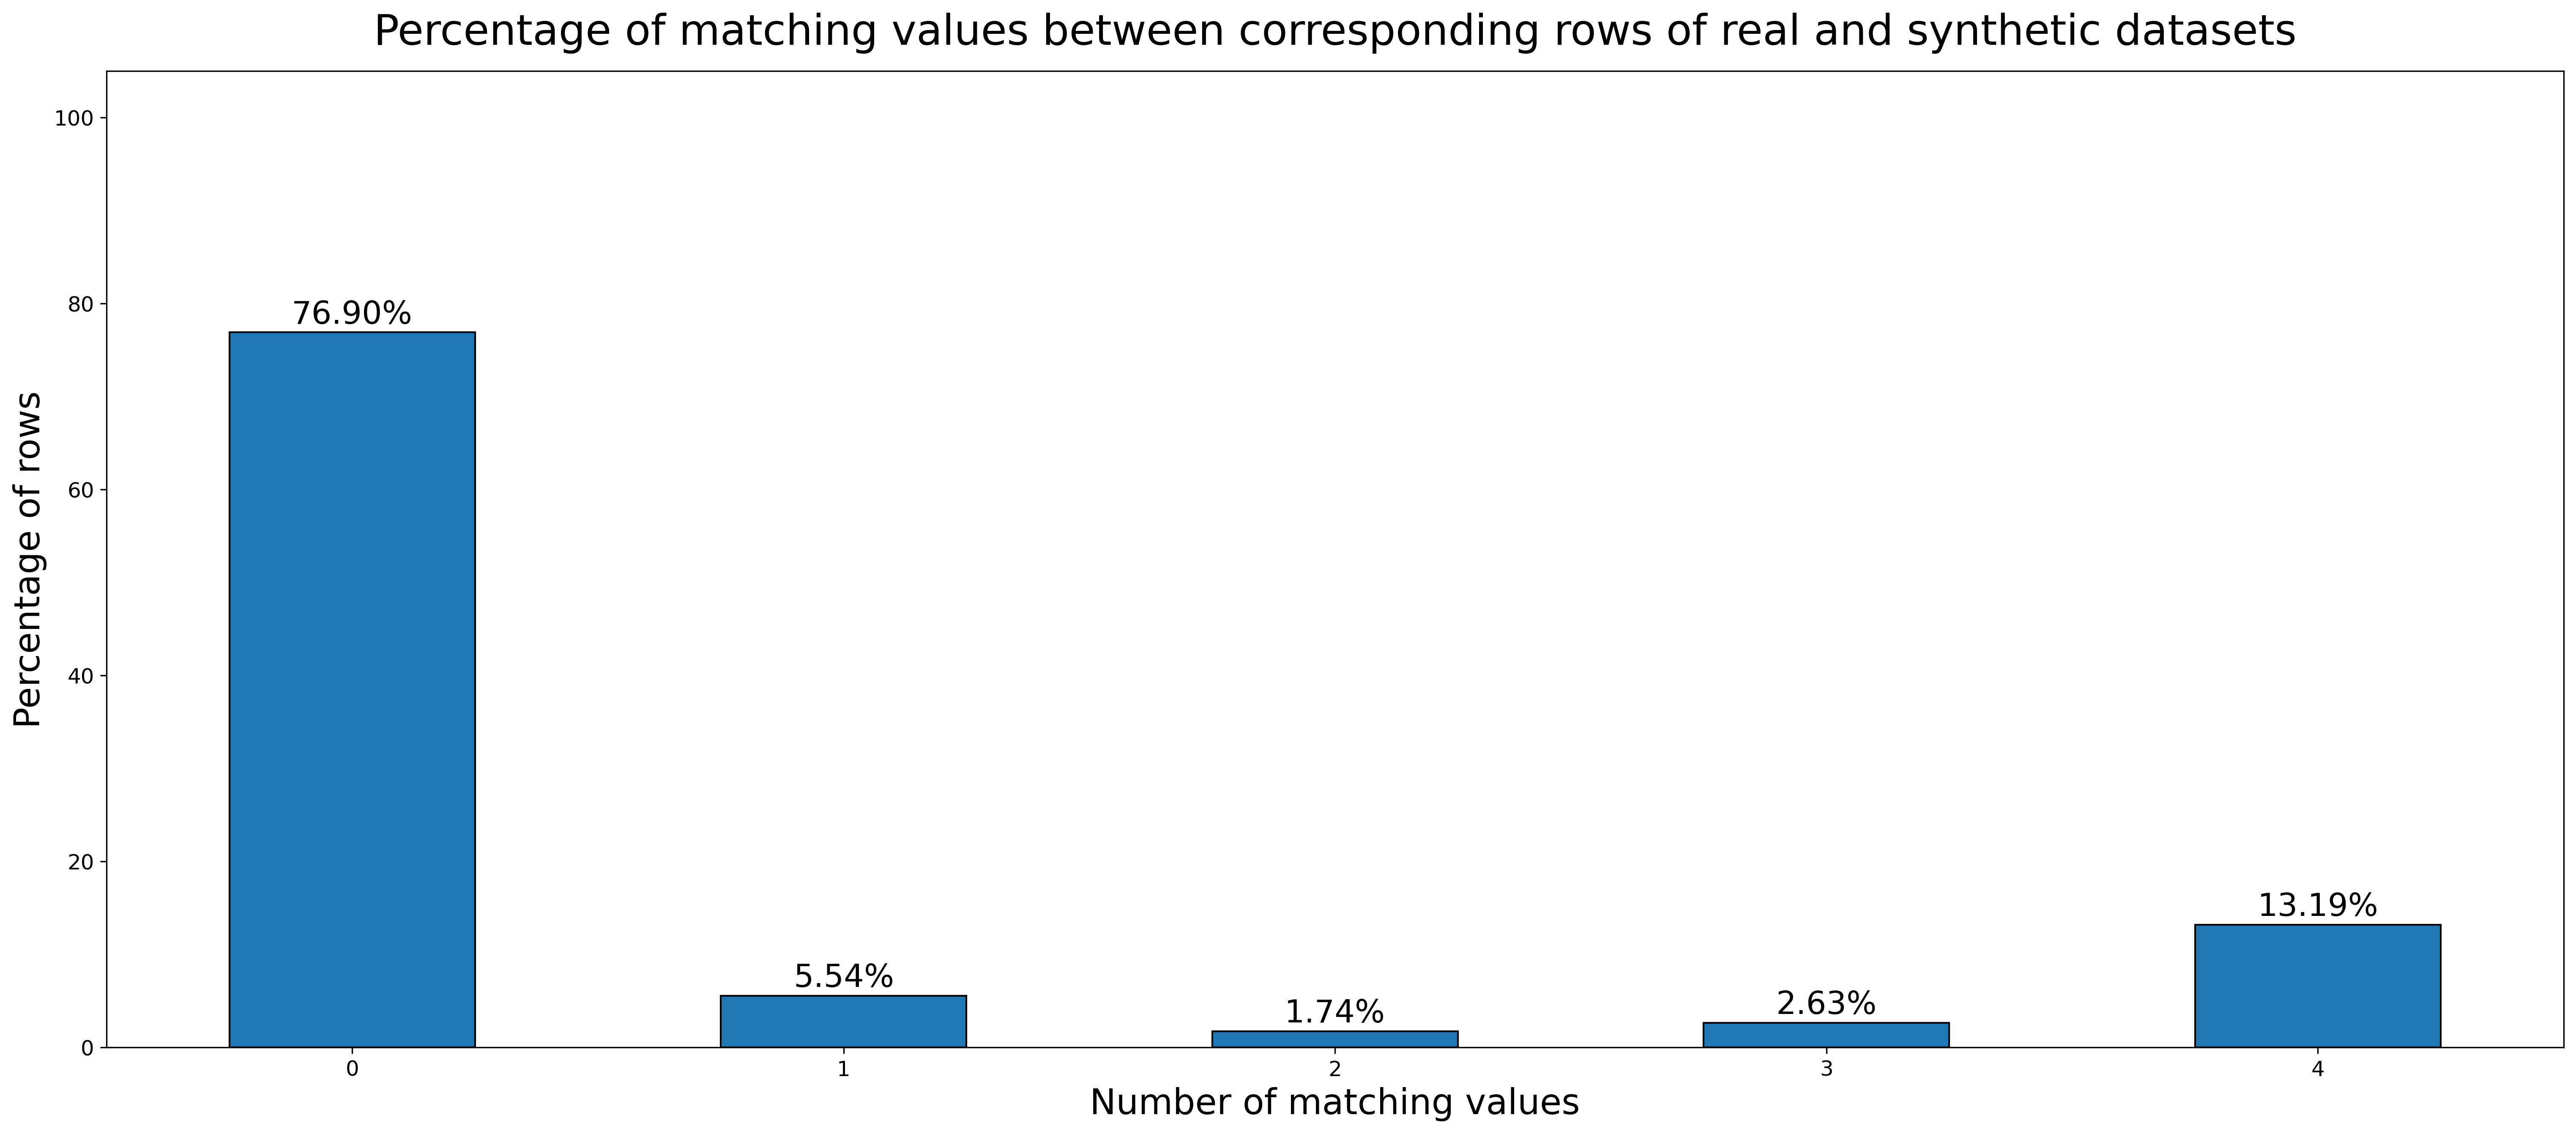

In [196]:
occurrences = pd.Series(distances).value_counts().sort_index()/len(distances) * 100

plt.figure(figsize=(25, 10), dpi=300)
ax = occurrences.plot(kind='bar', color='#1f77b4', edgecolor='black')

plt.xlabel('Number of matching values', fontsize=20)
plt.ylabel('Percentage of rows', fontsize=20)
plt.title('Percentage of matching values between corresponding rows of real and synthetic datasets', fontsize=24, pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=18,
                color='black')

plt.ylim(0, 105)

plt.show()

In [197]:
print("Report of Copied Variables:\n")
for variable, value in report.items():
    print(f"{variable.replace('_', ' ').capitalize()}: {value}")

Report of Copied Variables:

Page.loads: 369
First.time.visits: 356
Returning.visits: 402
Unique.visits: 357


### Discriminator

Another useful analysis can be conducted by implementing a ML discriminator that tries to detect synthetic data, in order to evaluate if these present any pattern that a ML model could find. We then implmented a RandomForest classifier, the datasets have been first labeled as `Real: 0` or `Synthetic: 1`, then merged and shuffled. On the merged dataset a static train-test-split has been applied and the classifier has been first trained and the tested.

In [198]:
def discriminator(real_data, synth_data):
    
    real_data['Synthetic'] = 0

    synth_data['Synthetic'] = 1
    
    combined_data = pd.concat([real_data, synth_data], axis=0)
    
    shuffled_df = combined_data.sample(frac=1).reset_index(drop=True)
    
    X = shuffled_df.drop('Synthetic', axis=1)
    y = shuffled_df['Synthetic']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rf = RandomForestClassifier(n_estimators=100)

    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)

    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))

In [199]:
df_F = df_filtered.drop(['Date'], axis=1)
df_S = df_sin.drop(['Date'], axis=1)

In [200]:
df_F.head(5)

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,0,2146.0,1582.0,1430.0,152.0
1,1,3621.0,2528.0,2297.0,231.0
2,2,3698.0,2630.0,2352.0,278.0
3,3,3667.0,2614.0,2327.0,287.0
4,4,3316.0,2366.0,2130.0,236.0


In [201]:
df_S.head(5)

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,3621.0,2528.0,2297.0,231.0
1,1,3621.0,2181.0,2297.0,231.0
2,0,2732.0,1941.0,1622.0,278.0
3,0,2116.0,1582.0,1414.0,231.0
4,3,3316.0,2613.0,2172.0,236.0


In [202]:
discriminator(df_F, df_S)

[[265 370]
 [429 226]]
              precision    recall  f1-score   support

           0       0.38      0.42      0.40       635
           1       0.38      0.35      0.36       655

    accuracy                           0.38      1290
   macro avg       0.38      0.38      0.38      1290
weighted avg       0.38      0.38      0.38      1290

0.3806201550387597


### Distance to the closest record (DCR)

To quantify the similarity between synthetic data and original data, we use a distance to closest record (DCR) calculation. This method involves two steps:

1. **Calculating the Euclidean Distance for Original Data**: For each datapoint in the original dataset, we calculate the Euclidean distance to its nearest neighbor within the same dataset.

2. **Calculating the Euclidean Distance for Synthetic Data**: For each synthetic datapoint, we calculate the Euclidean distance to the closest datapoint in the original dataset.

A greater synthetic-real DCR indicates that the synthetic datapoint is more distinct from the real datapoint, suggesting higher privacy since re-identification is more difficult. Conversely, a synthetic-real DCR close to 0 means that the synthetic datapoint closely resembles a real datapoint, offering little to no privacy protection.

Interpreting synthetic-real DCRs can be challenging because synthetic data points are designed to fall within the same range as the original data, increasing the likelihood of proximity to a real record. To address this, we compare the distribution of distances between synthetic records and real records with the distribution of distances among real records themselves. If the synthetic data is similar or farther from the real data compared to the real data's internal distances, it implies that the synthetic data provides good privacy privacy and is not merely a copy or simple perturbation of the real data.


In [203]:
def compute_dcr_optimized(real_df, synthetic_df):

    real_distances = cdist(real_df.values, real_df.values)
    np.fill_diagonal(real_distances, np.inf)
    
    synthetic_to_real_distances = cdist(synthetic_df.values, real_df.values)
    

    real_dcr = np.min(real_distances, axis=1)
    
    synthetic_dcr = np.min(synthetic_to_real_distances, axis=1)
    
    return real_dcr, synthetic_dcr

In [204]:
df_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Day.Of.Week        2167 non-null   int8   
 1   Page.Loads         2167 non-null   float64
 2   Unique.Visits      2167 non-null   float64
 3   First.Time.Visits  2167 non-null   float64
 4   Returning.Visits   2167 non-null   float64
 5   Synthetic          2167 non-null   int64  
dtypes: float64(4), int64(1), int8(1)
memory usage: 86.9 KB


In [205]:
real_dcr_o, synthetic_dcr_o = compute_dcr_optimized(df_F, df_S)

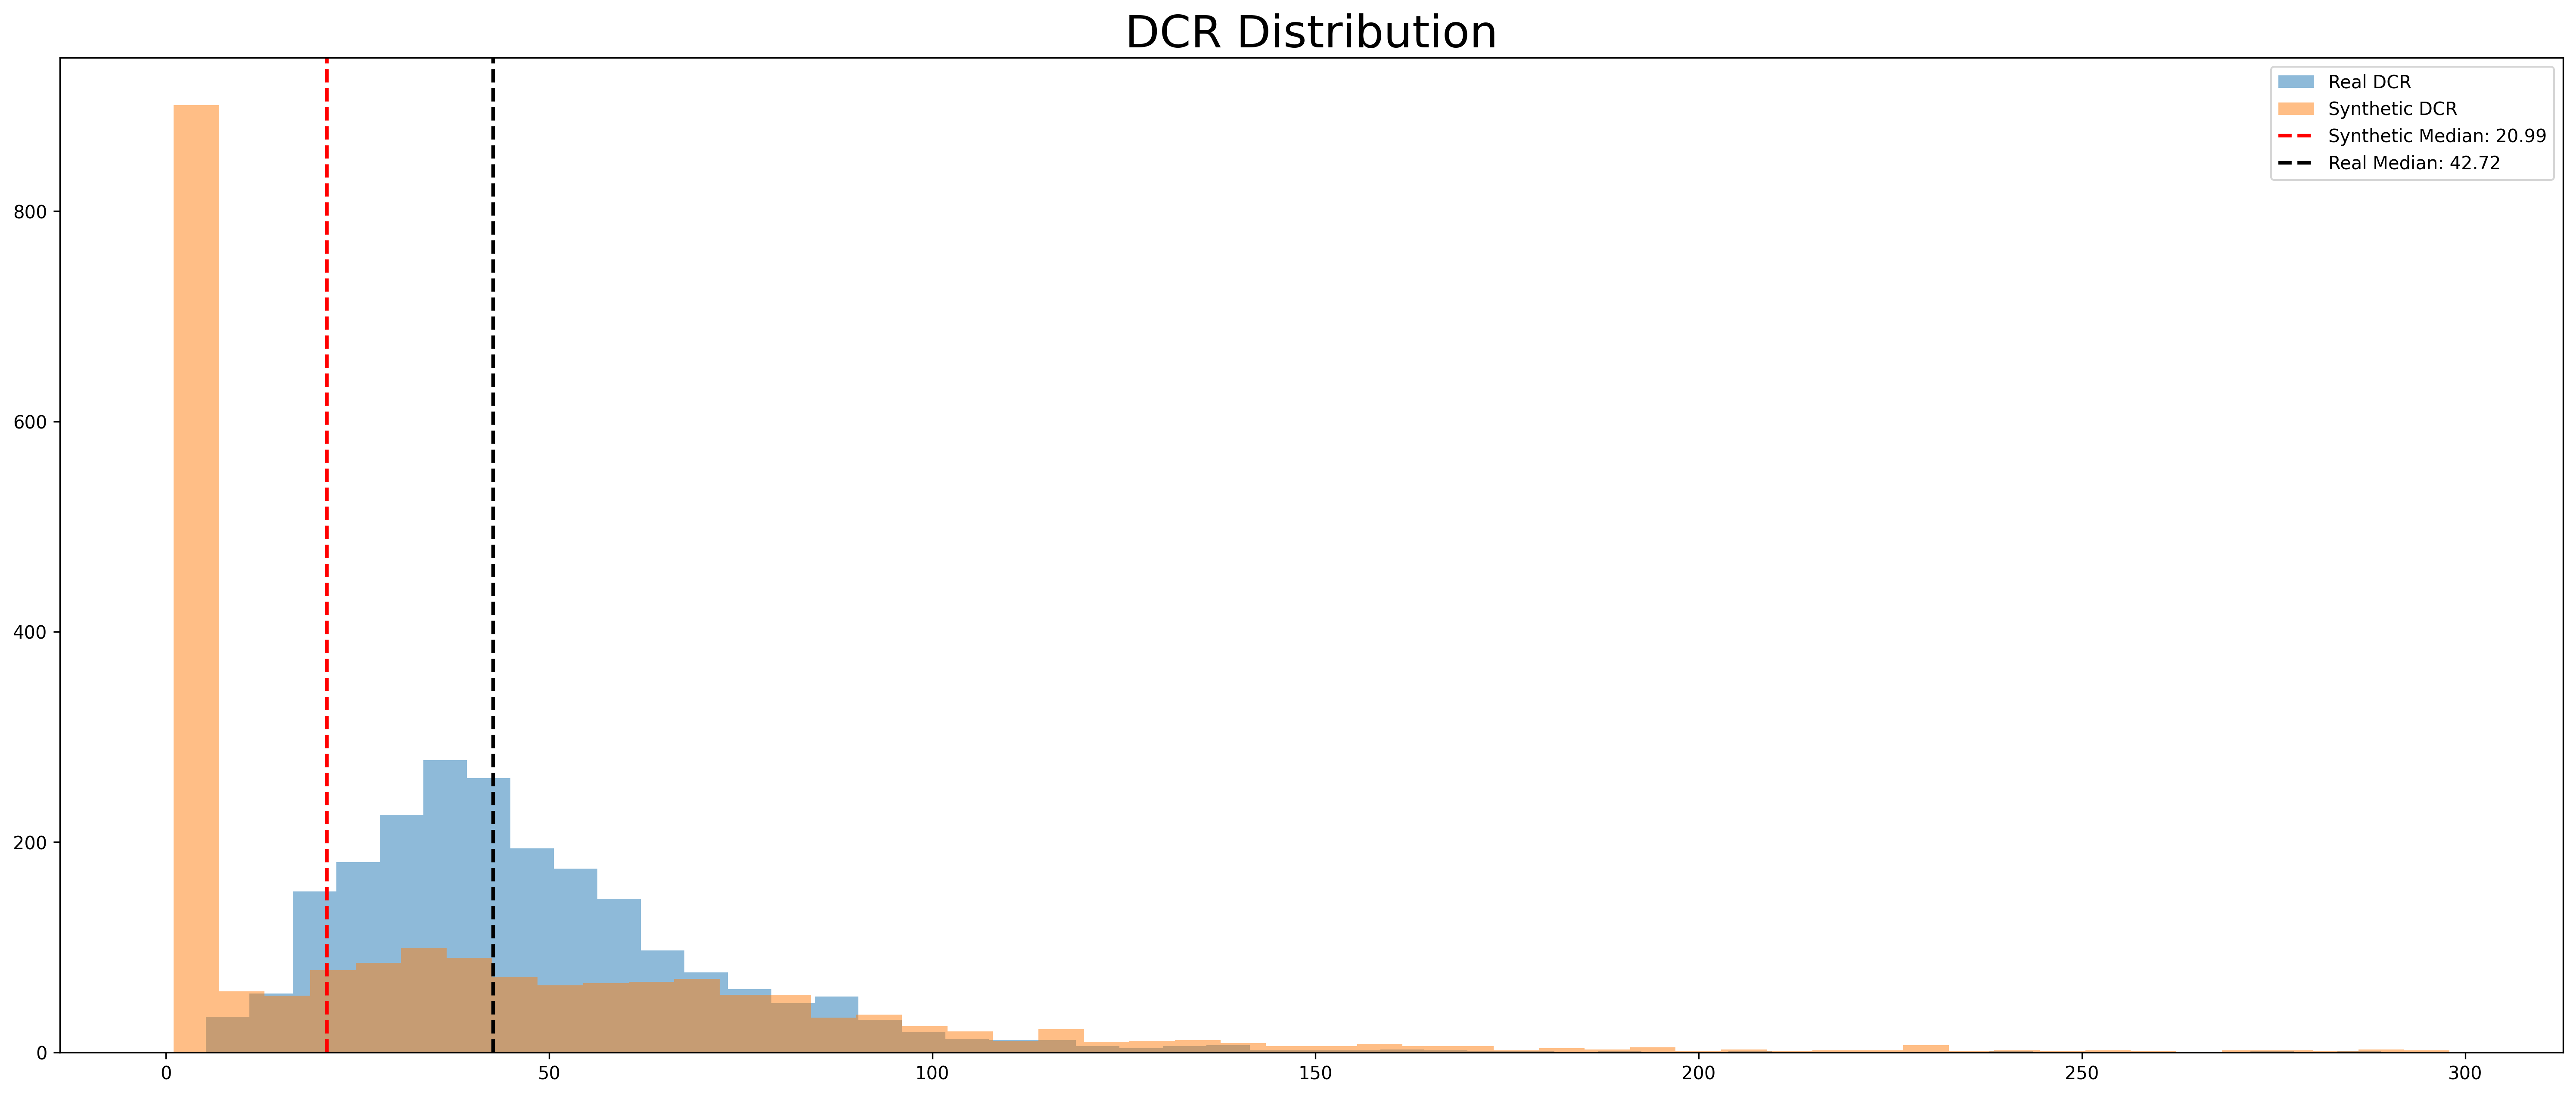

In [207]:
selected_values = synthetic_dcr_o[synthetic_dcr_o < 300]
sv = real_dcr_o[real_dcr_o < 300]
synth_median = np.median(selected_values)
real_median = np.median(sv)

plt.figure(figsize=(25, 10), dpi=300)

plt.title('DCR Distribution', fontsize=25)

plt.hist(sv, bins = 50 ,alpha=0.5, label='Real DCR')
plt.hist(selected_values, bins = 50 ,alpha=0.5, label='Synthetic DCR')

plt.axvline(synth_median, color='red', linestyle='dashed', linewidth=2, label=f'Synthetic Median: {synth_median:.2f}')
plt.axvline(real_median, color='black', linestyle='dashed', linewidth=2, label=f'Real Median: {real_median:.2f}')

plt.legend()

plt.show()

### Machine learning efficiency (MLE)

As last we try to build a simple machine learning model on the data to compare the efficiency of synthetic data with respect to the real. To do this we **train** a model on the synthetic data and test it on the real, in order to verify how efficient the synthetic data would be. We then compare the accuraxcy of the model with the one of a model trained and testd on the real data. As model we use a simple ``RandomForest`` classifier, using as target variable ``Day``.

In [93]:
seed = 12

X_s = df_sin.drop(['Day.Of.Week', 'Date'], axis=1)
y_s = df_sin['Day.Of.Week']

X = df_filtered.drop(['Day.Of.Week', 'Date'], axis=1)
y = df_filtered['Day.Of.Week']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf.fit(X_s, y_s)

predictions = rf.predict(X_test)

print('======= Random Forest - SYNTHETIC train REAL test =======')
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('                     Accuracy: ',round(accuracy_score(y_test, predictions),2),'\n')

rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

print('======= Random Forest - REAL train REAL test =======')
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('                     Accuracy: ',round(accuracy_score(y_test, predictions),2),'\n')


======= Random Forest - SYNTHETIC train REAL test =======
[[40  6  4  4  3 23 10]
 [ 3 51 12  7 11  6  3]
 [ 4 13 58  7  5 11  0]
 [ 9 16 12 43 13  8  2]
 [ 3 11 11 11 36  6  1]
 [ 7  5  7  5  5 58  6]
 [25  0  1  0  1 10 58]]
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        90
           1       0.50      0.55      0.52        93
           2       0.55      0.59      0.57        98
           3       0.56      0.42      0.48       103
           4       0.49      0.46      0.47        79
           5       0.48      0.62      0.54        93
           6       0.72      0.61      0.66        95

    accuracy                           0.53       651
   macro avg       0.53      0.53      0.53       651
weighted avg       0.54      0.53      0.53       651

                     Accuracy:  0.53 

======= Random Forest - REAL train REAL test =======
[[26  3  3  2 10 18 28]
 [ 7 12 27 13 23  7  4]
 [ 4 14 21 22 23 12  2]
 [11 17 20 2